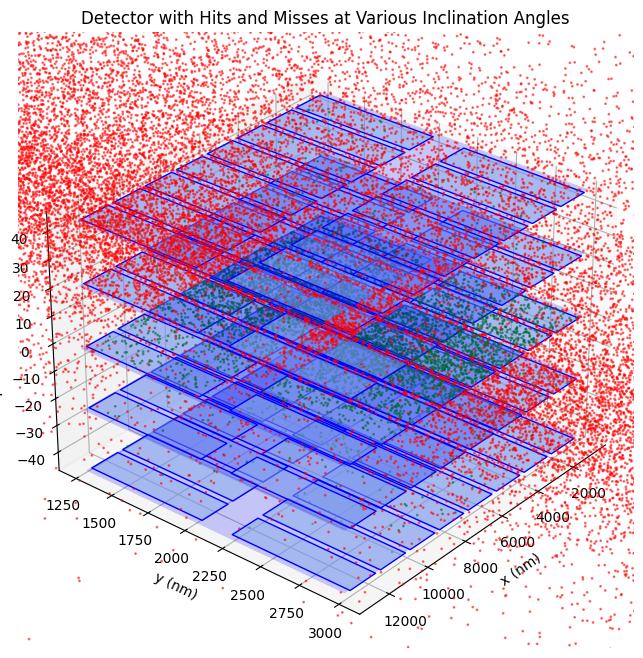

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.special import j1

# Simulation Parameters
N_photons = int(1e6)  # Number of photons to simulate
detector_width = 1550 * 8 + 730  # Total width of the detector in nm
detector_height = 2990 - 1270  # Total height of the detector in nm
distance_to_detector = 0.0001 * 1e9  # Distance from fiber to detector in nm
fiber_diameter = 8.2e-6 * 1e9  # Diameter of the fiber in nm
wavelength = 1555  # Wavelength of light in nm

# Define the active regions (in nm)
x = {'xmin': [i * 1550 + 480 for i in range(9)], 'xmax': [i * 1550 + 730 for i in range(9)]}
xactives = [(x['xmax'][i], x['xmin'][i+1]) for i in range(len(x['xmin'])-1)]
yactives = [(1270, 2030), (2230, 2990)]

# Define the additional y regions
yplus = {'ymin': 2230, 'ymax': 2990}
yneg = {'ymin': 1270, 'ymax': 2030}
y = [1270, 2030, 2230, 2990]

# Constants
k = 2 * np.pi / wavelength  # Wavenumber
fiber_aperture_radius = fiber_diameter / 2  # Radius of the fiber aperture in nm

# Inclination angles to plot
angles = np.linspace(-45, 45, 5)  # Adjust range and number of angles as needed

def simulate_hits_and_misses(inclination_angle):
    # Convert inclination angle to radians
    alpha = np.deg2rad(inclination_angle)

    # Generate random photon angles within the aperture
    theta = np.random.uniform(-np.pi/2, np.pi/2, N_photons)
    phi = np.random.uniform(0, 2*np.pi, N_photons)

    # Generate random positions within the fiber aperture
    r_aperture = np.random.uniform(0, fiber_aperture_radius, N_photons)
    phi_aperture = np.random.uniform(0, 2*np.pi, N_photons)
    x_aperture = r_aperture * np.cos(phi_aperture)
    y_aperture = r_aperture * np.sin(phi_aperture)

    # Rotate the positions by the inclination angle alpha
    z_hits = distance_to_detector * np.ones(N_photons)
    x_rotated = x_aperture
    y_rotated = y_aperture * np.cos(alpha) - z_hits * np.sin(alpha)
    z_rotated = y_aperture * np.sin(alpha) + z_hits * np.cos(alpha)

    # Project onto the detector plane
    x_hits = x_rotated + distance_to_detector * np.tan(theta) * np.cos(phi)
    y_hits = y_rotated + distance_to_detector * np.tan(theta) * np.sin(phi)

    # Adjust positions so that the center of the fiber aperture is at the center of the detector
    detector_center_x = detector_width / 2
    detector_center_y = detector_height / 2 + 1270  # Add ymin of the detector
    x_hits += detector_center_x
    y_hits += detector_center_y

    # Calculate the intensity of the Airy pattern at the detector plane
    r = np.sqrt(x_hits**2 + y_hits**2)
    airy_pattern = (2 * j1(k * r * fiber_diameter / (2 * distance_to_detector)) / (k * r * fiber_diameter / (2 * distance_to_detector))) ** 2
    airy_pattern /= airy_pattern.max()

    # Monte Carlo rejection sampling to accept photons based on Airy pattern
    acceptance = np.random.uniform(0, 1, N_photons)
    hits = acceptance <= airy_pattern

    # Update x and y positions with hits
    x_hits = x_hits[hits]
    y_hits = y_hits[hits]

    # Check if the photon hits the active areas on the detector
    hits_active_area = np.zeros_like(x_hits, dtype=bool)
    for xactive in xactives:
        xmin, xmax = xactive
        for yactive in yactives:
            ymin, ymax = yactive
            hits_active_area |= (
                (x_hits >= xmin) &
                (x_hits <= xmax) &
                (y_hits >= ymin) &
                (y_hits <= ymax)
            )

    return x_hits, y_hits, hits_active_area

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for angle in angles:
    x_hits, y_hits, hits_active_area = simulate_hits_and_misses(angle)

    # Plot the detector
    detector_vertices = np.array([
        [x['xmin'][0], y[0], angle],
        [x['xmax'][-1], y[0], angle],
        [x['xmax'][-1], y[-1], angle],
        [x['xmin'][0], y[-1], angle],
        [x['xmin'][0], y[0], angle]
    ])
    detector_faces = [[detector_vertices[0], detector_vertices[1], detector_vertices[2], detector_vertices[3]]]
    ax.add_collection3d(Poly3DCollection(detector_faces, facecolors='blue', alpha=0.2))

    # Plot the hits
    ax.scatter(x_hits[hits_active_area], y_hits[hits_active_area], zs=angle, s=1, c='green', label='Hits in Active Area', alpha=0.5)
    ax.scatter(x_hits[~hits_active_area], y_hits[~hits_active_area], zs=angle, s=1, c='red', label='Misses', alpha=0.5)

    # Plot active areas
    for xactive in xactives:
        xmin, xmax = xactive
        for yactive in yactives:
            ymax, ymin = yactive
            active_vertices = np.array([
                [xmin, ymin, angle],
                [xmax, ymin, angle],
                [xmax, ymax, angle],
                [xmin, ymax, angle],
                [xmin, ymin, angle]
            ])
            active_faces = [[active_vertices[0], active_vertices[1], active_vertices[2], active_vertices[3]]]
            ax.add_collection3d(Poly3DCollection(active_faces, facecolors='lightblue', edgecolors='blue', alpha=0.5))

# Set plot limits
ax.set_xlim(x['xmin'][0] - 100, x['xmax'][-1] + 100)
ax.set_ylim(y[0] - 100, y[-1] + 100)
ax.set_zlim(min(angles), max(angles))
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
ax.set_zlabel('Inclination Angle')
ax.set_title('Detector with Hits and Misses at Various Inclination Angles')

# Adjust the viewing angle for better visualization
ax.view_init(elev=30, azim=40)

plt.show()
